_Remark:_ this is just an example write up for the second part of the
first assignment. I highlighted a few observations I think needed to be
included in some form. Your report could be shorter and still contain all
required information and that is fine.

The implementation is of course not the only option (and I will not look too much into
the details of your code). As I pointed out in the assignment __code duplication__ is
something one really needs to avoid. For example I implemented a function
_experiment_ to perform the computation of the errors for the given time
steps and the eocs so that I could use that for both Q2.1 and Q2.2.

If there is some part of the code you don't understand then let me know
I'm happy to discuss details (and take suggestions for improvements on
board if you have any).

I split the submission up into a pdf and a python script both generated
from a notebook as I'm asking you to do for the second assignment to
simplify the marking. Make sure that 
- the pdf includes the executed cells (i.e. tables/plots other required output).
- test that the Python script runs on your machine before submission.

Assignment 1 part II
====================

Aim:
- Implementing two explicit solvers, the forward Euler and method from Q11.
- Study the convergence order and comparing the method using a non-linear 2x2 ODE system.

Initial imports including the three methods from the quizzes
('forwardEuler', 'evolve', 'computeEocs')

In [1]:
from IPython.display import display
import numpy as np
from numpy import array, exp, zeros, sqrt
from numpy.linalg import norm
from matplotlib import pyplot as plt
import pandas as pd

from forwardEuler import forwardEuler
from evolve import evolve
from computeEocs import computeEocs

Problem setup for ODE
$y'(t)=f(t,y(t))$ and $y(0)=y_0$ with right hand side
$$ f(t,y_1,y_2) = \left(\begin{array}{cc} y_2 \\[1ex] y_2(\lambda-2y_1) \end{array}\right) $$
With $\lambda=1$ and initial conditions $y_0=(2, -2)^T$ this has the exact solution
$$ Y(t) = \left(\begin{array}{cc}
     \frac{2e^t}{2e^t-1} \\[2ex]
     \frac{-2e^{t}}{4e^{2t}-4e^t+1}
\end{array}\right) $$
We will solve this on the interval $[0,T]$ with $T=10$.

In [2]:
T = 10
Y = lambda t: array([2*exp(t)/(2*exp(t)-1),
                     (-2*exp(t))/(4*exp(2*t)-4*exp(t)+1)])
def f(t,y):
    return array([y[1], y[1]*(1-2*y[0])])
def Df(t,y):
    return array([[0,1],[2*y[1],1-2*y[0]]])

Function to solve the problem given a 'stepper' (function for a single
step of the solver). The 'experiment' function computes maximum errors
up to the final time $T$ and the EOC for sequence of time steps given by
$h_i = \frac{T}{N_02^i}$ for $i=0,\dots,M$ with $M=10$ using $N_0=10$.

The method returns an array of length $M+1$ each entry of the form '[h,max-error,eoc]'.

In [3]:
def experiment(stepper):
    M    = 10
    N0   = 25
    herr = zeros( [M,2] )
    for m in range(M):
        N = N0*2**m
        t,y = evolve( stepper, f,Df, 0,Y(0),T, N)
        herr[m] = [T/N, 0]
        for tn,yn in zip(t,y):
            herr[m][1] = max(herr[m][1], norm(yn-Y(tn)) )

    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )

    return res

Simulations
-----------

Perform the simulation using the forwardEuler stepper

In [4]:
resFE = experiment(forwardEuler)

Perform the simulation using the method from Q1.1

In [5]:
def Q11( f,Df, t0,y0, h):
    f0 = f(t0,y0)
    f1 = f(t0+h, y0+h*f0)
    return y0 + h/2*(f0+f1)
resQ11 = experiment(Q11)

Results:
--------

Generate a table (using pandas) containing the computed results

,h,FE-error,FE-eoc,Q11-error,Q11-eoc
0,4.0000e-01,1.197520e+00,nan,2.336009e-01,nan
1,2.0000e-01,3.849013e-01,1.637,5.724377e-02,2.029
2,1.0000e-01,1.424462e-01,1.434,1.252991e-02,2.192
3,5.0000e-02,6.525497e-02,1.126,2.894328e-03,2.114
4,2.5000e-02,3.135656e-02,1.057,6.889803e-04,2.071
5,1.2500e-02,1.538350e-02,1.027,1.680073e-04,2.036
6,6.2500e-03,7.620535e-03,1.013,4.148271e-05,2.018
7,3.1250e-03,3.792678e-03,1.007,1.030578e-05,2.009
8,1.5625e-03,1.891968e-03,1.003,2.568356e-06,2.005
9,7.8125e-04,9.448989e-04,1.002,6.410798e-07,2.002


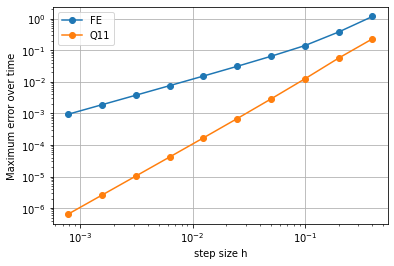

In [6]:
def compareErrors(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n}-error', f'{n}-eoc']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[2*i+1]]   = results[k][:,1] # errors
        styles[columns[2*i+1]] = '{:.6e}'
        keys[columns[2*i+2]]   = results[k][:,2] # eocs
        styles[columns[2*i+2]] = '{:.3f}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    plt.xlabel("step size h")
    plt.ylabel("Maximum error over time")
    plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight") # output to pdf for inclusing in tex document
    plt.show()


compareErrors({"FE":resFE,"Q11":resQ11})

Summary Q2.1
------------

Consider the above Table which shows the error and eoc for the forward
Euler method in the second and third column for different time steps
given in the first column.

The experimental order of convergence shown in the third column clearly indicates that the
method is __converging with order $1$__.
This is in accordance with the __result proven in the lecture__, where we showed linear
convergence for the forward Euler method. The results proven there were
$$ \max_{n}|y_n-Y(t_n)| = O(h) $$

Summary Q2.2
------------

In the last two columns of the above Table simulation results are
summarized for the method given in Question 1.1.
The last column showing the experimental order of convergence indicates
that the method is converging __quadratically__. This matches the rate
stated in the question.

_Could add (nice but was not required): further tests I made with linear right hand side and with
$f(t)=\cos(t)$ confirm the quadratic convergence._

Summary Q2.3
------------

In this question we were to compare the two method. We have already shown
a figure comparing the errors of both methods with respect to the step
size.
This figure clearly shows the _advantage of the higher convergence rate_
of # the method from Q1.1 for a given step size. This is expected from a method
that converges quadratically over a method with convergence order $1$. 
For all step sizes the Q1.1 method outperforms the forward Euler
method, which indicates that the constant in the error estimate of the
Q1.1 method is not significantly higher compared to the constant in
the estimate for the forward Euler method.

Finally, we compare the efficiency of the two methods.

Each step of the Euler method __requires a single evaluation__ of the right
hand side function $f$ in each step while the method from Q1.1
__requires two evaluations__.
Therefore, the computational cost of the method from Q1.1
measured by the number of evaluations of $f$ to simulate up to a fixed time $T$
will be __twice the cost__ of the forward Euler method.
This measure is used on the $x$ axis in the final Figure showing
the error for a given computational cost.

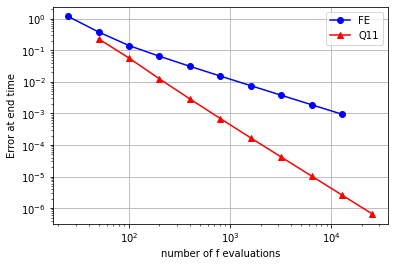

In [7]:
def compareEff(res1,res2,name1,name2):
    plt.loglog(T/res1[:,0],res1[:,1],'bo-',label=name1)
    plt.loglog(2*T/res2[:,0],res2[:,1],'r^-',label=name2)
    plt.legend()
    plt.grid(True)
    plt.xlabel("number of f evaluations")
    plt.ylabel("Error at end time")
    plt.savefig("Q2_compareEff.pdf", format="pdf", bbox_inches="tight")
    plt.show()
compareEff(resFE,resQ11,"FE","Q11")

Clearly __for this problem__ the method from Q1.1 outperforms the Forward
Euler method even for large time steps. For example to achieve an error of
$10^{-3}$ at the final time $T=2.5$ the method from Q1.1 requires an order
of magnitude less evaluations of $f$ then the Forward Euler method. The
gap greatly increases if smaller errors are required.

Summary Q2.4
------------

In this question we were to compare the two method but for a different
scalar ODE. With the give exact solution
\begin{align*}
Y(t) = \begin{cases}
   \sin(t)                & t<\frac{\pi}{2}     \\
   \exp(t-\frac{\pi}{2}) & t\geq\frac{\pi}{2}
   \end{cases}
\end{align*}
the right hand side $f(t,y)$ needs to be
$$ f(t,y) = \begin{cases}
   \cos(t) & t<\frac{\pi}{2} \\
   y & t\geq\frac{\pi}{2}
   \end{cases} $$

,h,FE-error,FE-eoc,Q11-error,Q11-eoc
0,1.2000e-01,4.902344e-01,nan,2.210943e-01,nan
1,6.0000e-02,2.411621e-01,1.023,8.456613e-02,1.387
2,3.0000e-02,1.031845e-01,1.225,1.870873e-02,2.176
3,1.5000e-02,3.040886e-02,1.763,1.346657e-02,0.474
4,7.5000e-03,2.404592e-02,0.339,1.968994e-03,2.774
5,3.7500e-03,5.228799e-03,2.201,5.915761e-03,-1.587
6,1.8750e-03,3.565765e-03,0.552,2.015447e-03,1.553
7,9.3750e-04,2.731073e-03,0.385,6.177275e-05,5.028
8,4.6875e-04,2.312930e-03,0.240,9.159465e-04,-3.890
9,2.3437e-04,1.125334e-03,1.039,4.264240e-04,1.103


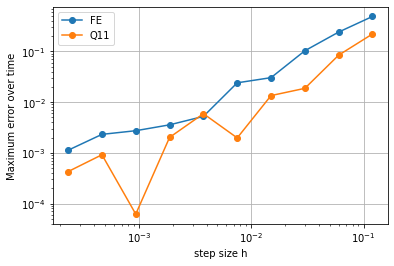

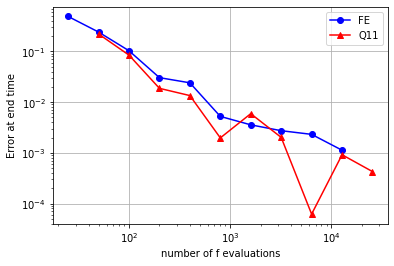

In [8]:
T = 3
tbar = np.pi/2
def Y(t):
    return ( np.array( [np.sin(t)] )
             if t<tbar else np.array( [np.exp(t-tbar)] ) )
def f(t,y):
    return ( np.array( [np.cos(t)] )
             if t<tbar else np.array( [y] ) )
def Df(t,y):
    return ( np.array( [0] )
             if t<tbar else np.array( [0] ) )
resFE = experiment(forwardEuler)
resQ11 = experiment(Q11)
compareErrors({"FE":resFE,"Q11":resQ11})
compareEff(resFE,resQ11,"FE","Q11")

In this case both method perform very similar - they both __still converge__
Both method seem to converge with a rate of $1$ --
we do not see the higher order of the Q11 method.

Since the exact solution is __not__ $C^2$ (and definitely not $C^3$) anymore
the __convergence theory__ for both method is __not applicable__. So we
don not know if the method even converge or what their convergence rate
might be in this case. It is interesting to see that apparently the
method still converge even for a solution that is not even $C^1$
(at least the right hand side is still Lipschitz in $y$ uniformly in $t$).